# 阶段1：无监督特征重要性分析

本notebook完成以下任务：
1. 加载训练集数据
2. 方差分析（移除低方差特征）
3. 相关性分析（移除高相关特征）
4. PCA分析（识别重要特征）
5. 聚类分析（特征区分能力）
6. 互信息分析（特征与聚类标签）
7. 综合评分，选择Top-K特征
8. 保存结果


In [3]:
# 导入必要的库和配置
%run 00_config_and_setup.ipynb

import config
from utils.data_utils import load_intermediate, save_intermediate
from utils.visualization_utils import plot_feature_importance, plot_correlation_matrix

print("准备开始无监督特征选择...")


✓ 所有库导入完成
✓ 配置文件加载完成
项目根目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025
输出目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs
中间结果目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
✓ 显示选项设置完成
✓ 输出目录创建完成
  - 中间结果: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
  - 模型文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models
  - 报告文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports
  - 可视化: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations
✓ 随机种子设置为: 42
✓ 可视化样式设置完成: seaborn-v0_8
✓ 工具函数导入完成
准备开始无监督特征选择...


## 1. 加载数据


In [4]:
# 加载训练集数据和特征名称
train_data = load_intermediate('train_data')
feature_names = load_intermediate('feature_names')

print(f"训练集形状: {train_data.shape}")
print(f"特征数量: {len(feature_names)}")

# 提取特征列（排除非特征列）
exclude_cols = ['group', 'window', 'window_idx', 'window_start', 'pair']
feature_cols = [col for col in feature_names if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
print(f"实际特征数: {len(feature_cols)}")


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\feature_names.pkl
训练集形状: (67447, 117)
特征数量: 113
实际特征数: 113


## 2. 方差分析


特征方差统计:
最小值: 0.000000
最大值: 1.000015
平均值: 0.929217
中位数: 1.000015


C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\4085597208.py:18: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\4085597208.py:18: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\4085597208.py:18: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\4085597208.py:18: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\4085597208.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\4085597208.py:18: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missi

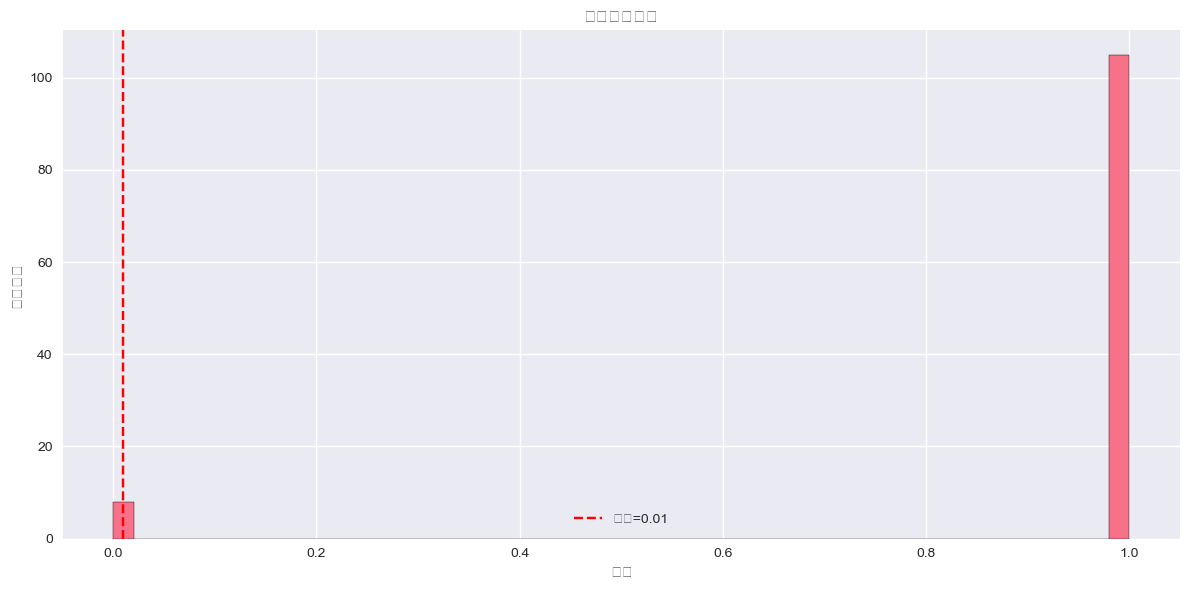


低方差特征数 (< 0.01): 8
保留特征数 (>= 0.01): 105


In [5]:
# 计算每个特征的方差
variances = X_train.var()
print(f"特征方差统计:")
print(f"最小值: {variances.min():.6f}")
print(f"最大值: {variances.max():.6f}")
print(f"平均值: {variances.mean():.6f}")
print(f"中位数: {variances.median():.6f}")

# 可视化方差分布
plt.figure(figsize=(12, 6))
plt.hist(variances, bins=50, edgecolor='black')
plt.axvline(config.UNSUPERVISED_CONFIG['variance_threshold'], 
           color='r', linestyle='--', label=f"阈值={config.UNSUPERVISED_CONFIG['variance_threshold']}")
plt.xlabel('方差')
plt.ylabel('特征数量')
plt.title('特征方差分布')
plt.legend()
plt.tight_layout()
plt.show()

# 移除低方差特征
variance_threshold = config.UNSUPERVISED_CONFIG['variance_threshold']
low_variance_features = variances[variances < variance_threshold].index.tolist()
high_variance_features = variances[variances >= variance_threshold].index.tolist()

print(f"\n低方差特征数 (< {variance_threshold}): {len(low_variance_features)}")
print(f"保留特征数 (>= {variance_threshold}): {len(high_variance_features)}")

# 保存方差分数
variance_scores = variances.to_dict()


## 3. 相关性分析


C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:80: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:80: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:80: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:80: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:80: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Share

已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations\correlation_matrix_unsupervised.png


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabto

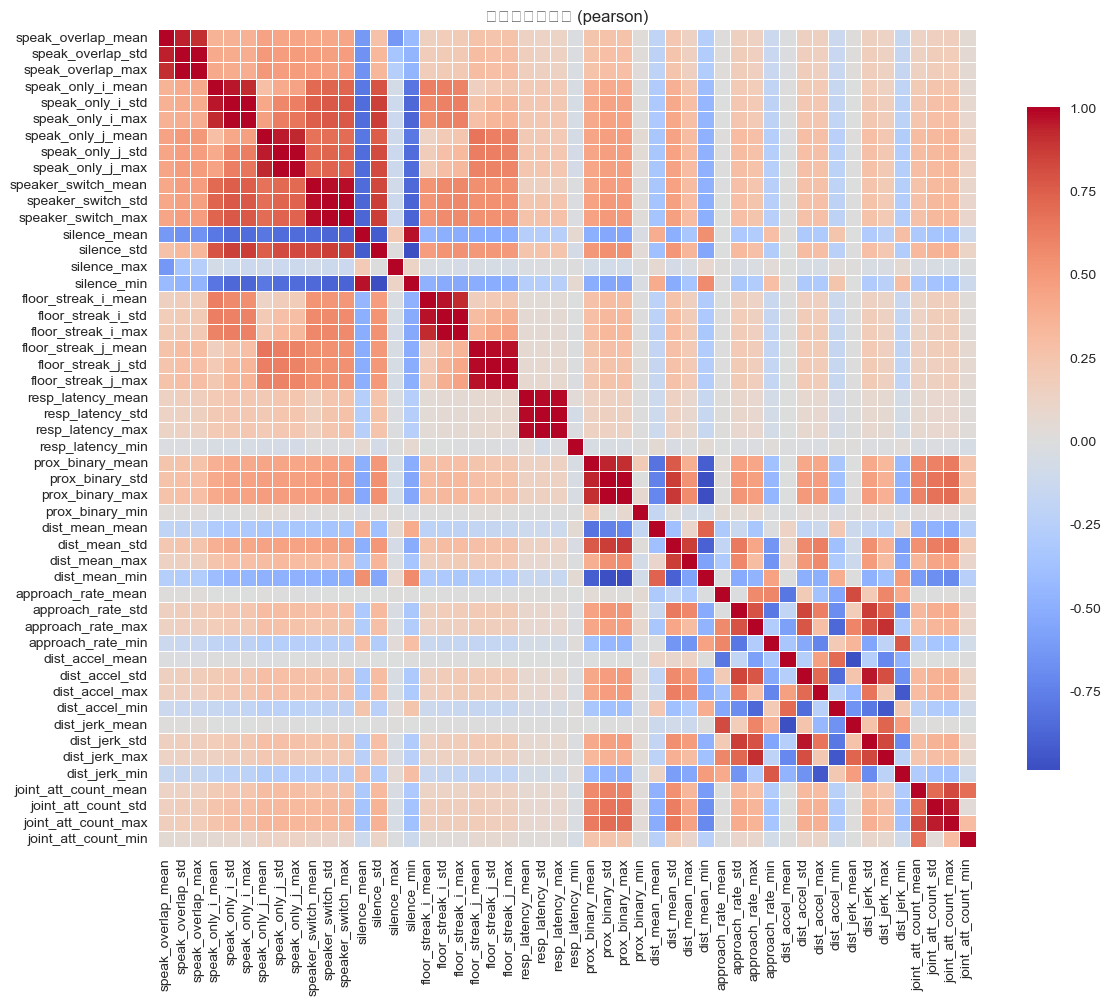


高相关特征对数 (>0.95): 86
移除高相关特征后剩余: 67 个特征


In [6]:
# 只对高方差特征进行相关性分析
X_high_var = X_train[high_variance_features]

# 计算相关性矩阵
corr_matrix = X_high_var.corr().abs()

# 可视化相关性矩阵（只显示前50个特征，避免过大）
n_display = min(50, len(high_variance_features))
plot_correlation_matrix(
    X_high_var.iloc[:, :n_display],
    save_path=config.VISUALIZATIONS_DIR / "correlation_matrix_unsupervised.png"
)

# 找出高相关特征对
correlation_threshold = config.UNSUPERVISED_CONFIG['correlation_threshold']
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"\n高相关特征对数 (>{correlation_threshold}): {len(high_corr_pairs)}")

# 移除高相关特征（保留方差较大的那个）
features_to_remove = set()
for feat1, feat2, corr_val in high_corr_pairs:
    if feat1 not in features_to_remove and feat2 not in features_to_remove:
        # 保留方差较大的特征
        if variance_scores[feat1] >= variance_scores[feat2]:
            features_to_remove.add(feat2)
        else:
            features_to_remove.add(feat1)

features_after_corr = [f for f in high_variance_features if f not in features_to_remove]
print(f"移除高相关特征后剩余: {len(features_after_corr)} 个特征")


## 4. PCA分析


主成分数量: 67
前10个主成分解释的方差比例:
  PC1: 0.2809 (28.09%)
  PC2: 0.1221 (12.21%)
  PC3: 0.0841 (8.41%)
  PC4: 0.0609 (6.09%)
  PC5: 0.0595 (5.95%)
  PC6: 0.0497 (4.97%)
  PC7: 0.0424 (4.24%)
  PC8: 0.0378 (3.78%)
  PC9: 0.0300 (3.00%)
  PC10: 0.0274 (2.74%)

解释95.0%方差需要的主成分数: 21


C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\2841856801.py:39: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\2841856801.py:39: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\2841856801.py:39: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\2841856801.py:39: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\2841856801.py:39: UserWarning: Glyph 37322 (\N{CJK UNIFIED IDEOGRAPH-91CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_5876\2841856801.py:39: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missi

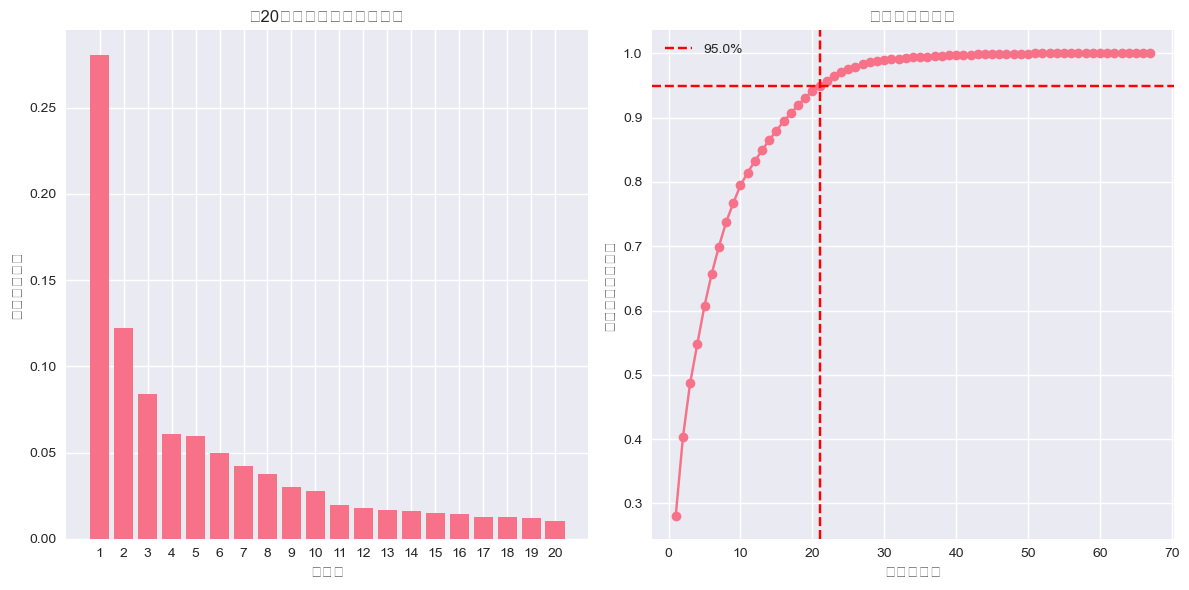

In [7]:
# 对剩余特征进行PCA分析
X_pca = X_train[features_after_corr]

# 执行PCA
pca = PCA(n_components=config.UNSUPERVISED_CONFIG['pca_n_components'])
X_pca_transformed = pca.fit_transform(X_pca)

# 分析主成分贡献率
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"主成分数量: {len(explained_variance_ratio)}")
print(f"前10个主成分解释的方差比例:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"  PC{i+1}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:.2f}%)")

n_components_95 = np.where(cumulative_variance >= config.UNSUPERVISED_CONFIG['pca_variance_ratio'])[0][0] + 1
print(f"\n解释{config.UNSUPERVISED_CONFIG['pca_variance_ratio']*100}%方差需要的主成分数: {n_components_95}")

# 可视化主成分贡献率
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, min(21, len(explained_variance_ratio)+1)), 
        explained_variance_ratio[:20])
plt.xlabel('主成分')
plt.ylabel('解释方差比例')
plt.title('前20个主成分的方差贡献率')
plt.xticks(range(1, min(21, len(explained_variance_ratio)+1)))

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'o-')
plt.axhline(config.UNSUPERVISED_CONFIG['pca_variance_ratio'], 
           color='r', linestyle='--', label=f"{config.UNSUPERVISED_CONFIG['pca_variance_ratio']*100}%")
plt.axvline(n_components_95, color='r', linestyle='--')
plt.xlabel('主成分数量')
plt.ylabel('累积解释方差比例')
plt.title('累积方差解释率')
plt.legend()
plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / "pca_analysis.png", dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()

# 计算每个原始特征对主成分的贡献（使用前n_components_95个主成分）
pca_components = pca.components_[:n_components_95, :]
feature_importance_pca = np.abs(pca_components).mean(axis=0)  # 平均绝对贡献
pca_scores = dict(zip(features_after_corr, feature_importance_pca))


## 5. 聚类分析


In [8]:
# 使用K-means对窗口进行聚类
n_clusters = config.UNSUPERVISED_CONFIG['n_clusters']
kmeans = KMeans(n_clusters=n_clusters, random_state=config.RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

print(f"聚类完成，聚类数: {n_clusters}")
print(f"各聚类的样本数:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  聚类{label}: {count} 个样本")

# 分析哪些特征最能区分不同聚类
# 使用F统计量（组间方差/组内方差）
from scipy.stats import f_oneway

cluster_importance = {}
for feature in features_after_corr:
    groups = [X_pca[cluster_labels == i][feature].values for i in range(n_clusters)]
    groups = [g for g in groups if len(g) > 0]  # 移除空组
    if len(groups) > 1:
        f_stat, p_value = f_oneway(*groups)
        cluster_importance[feature] = f_stat
    else:
        cluster_importance[feature] = 0

cluster_scores = cluster_importance
print(f"\n聚类分析完成，计算了{len(cluster_importance)}个特征的区分能力")


d:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "d:\Anaconda\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Anaconda\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
              

聚类完成，聚类数: 5
各聚类的样本数:
  聚类0: 61397 个样本
  聚类1: 1380 个样本
  聚类2: 554 个样本
  聚类3: 2427 个样本
  聚类4: 1689 个样本

聚类分析完成，计算了67个特征的区分能力


## 6. 互信息分析


In [9]:
# 计算特征与聚类标签的互信息
# 注意：mutual_info_classif需要离散化的特征，这里使用默认的离散化
mi_scores = mutual_info_classif(
    X_pca, 
    cluster_labels, 
    random_state=config.RANDOM_STATE
)

mi_scores_dict = dict(zip(features_after_corr, mi_scores))
print(f"互信息分析完成，计算了{len(mi_scores_dict)}个特征")

# 可视化互信息分数
top_mi_features = sorted(mi_scores_dict.items(), key=lambda x: x[1], reverse=True)[:20]
top_mi_df = pd.DataFrame(top_mi_features, columns=['feature', 'mutual_info'])
print(f"\n前20个特征的互信息分数:")
display(top_mi_df)


互信息分析完成，计算了67个特征

前20个特征的互信息分数:


,feature,mutual_info
0,bigram_entropy_mean,0.4059
1,dominance_ratio_max,0.4057
2,material_diversity_min,0.4057
3,fano_switch_max,0.4056
4,fano_switch_min,0.4055
5,dominance_ratio_std,0.4055
6,material_diversity_max,0.4037
7,dominance_ratio_mean,0.4037
8,total_interactions,0.4036
9,dominance_ratio_min,0.4035


## 7. 综合评分和特征选择


In [10]:
# 综合评分：归一化各方法的分数后加权平均
def normalize_scores(scores_dict):
    """将分数归一化到[0, 1]"""
    scores_array = np.array(list(scores_dict.values()))
    if scores_array.max() > scores_array.min():
        normalized = (scores_array - scores_array.min()) / (scores_array.max() - scores_array.min())
    else:
        normalized = np.ones_like(scores_array)
    return dict(zip(scores_dict.keys(), normalized))

# 归一化各方法的分数
variance_norm = normalize_scores({f: variance_scores[f] for f in features_after_corr})
pca_norm = normalize_scores(pca_scores)
cluster_norm = normalize_scores(cluster_scores)
mi_norm = normalize_scores(mi_scores_dict)

# 综合评分（加权平均）
weights = {
    'variance': 0.2,
    'pca': 0.3,
    'cluster': 0.3,
    'mutual_info': 0.2
}

combined_scores = {}
for feature in features_after_corr:
    combined_scores[feature] = (
        weights['variance'] * variance_norm[feature] +
        weights['pca'] * pca_norm[feature] +
        weights['cluster'] * cluster_norm[feature] +
        weights['mutual_info'] * mi_norm[feature]
    )

# 按综合分数排序
sorted_features = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

print(f"综合评分完成，共{len(sorted_features)}个特征")
print(f"\n前20个特征的综合分数:")
top_features_df = pd.DataFrame(sorted_features[:20], columns=['feature', 'combined_score'])
display(top_features_df)


综合评分完成，共67个特征

前20个特征的综合分数:


,feature,combined_score
0,dominance_ratio_std,0.6310
1,bigram_entropy_mean,0.6163
2,eigenvector_conversation,0.5380
3,material_diversity_min,0.5222
4,material_diversity_mean,0.4862
5,participant_D_interactions,0.4858
6,dominance_ratio_max,0.4853
7,total_interactions,0.4829
8,participant_B_interactions,0.4815
9,fano_switch_std,0.4708



选择的Top-50特征:
特征数量: 50


C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Share

已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations\feature_importance_unsupervised.png


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabto

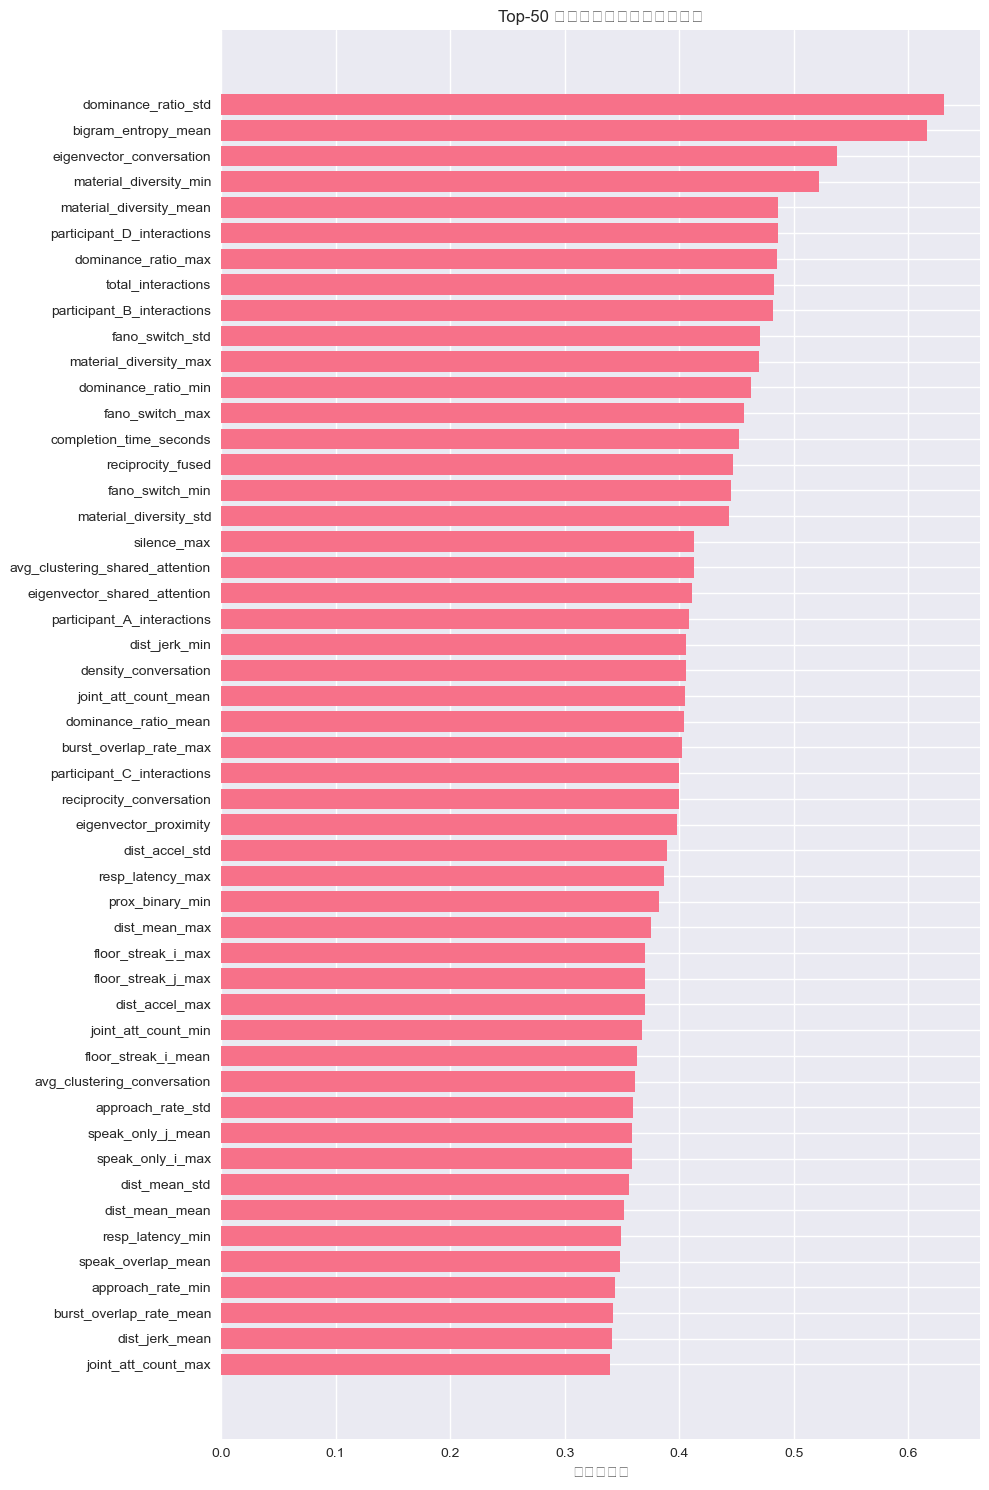

In [11]:
# 选择Top-K特征
top_k = config.UNSUPERVISED_CONFIG['top_k']
top_k_features = [f[0] for f in sorted_features[:top_k]]

print(f"\n选择的Top-{top_k}特征:")
print(f"特征数量: {len(top_k_features)}")

# 可视化特征重要性
importance_scores = [f[1] for f in sorted_features[:top_k]]
plot_feature_importance(
    importance_scores,
    top_k_features,
    top_n=top_k,
    title=f"Top-{top_k} 特征重要性（无监督方法）",
    save_path=config.VISUALIZATIONS_DIR / "feature_importance_unsupervised.png"
)


## 8. 保存结果


In [12]:
# 保存选择的特征
save_intermediate('top_k_features', top_k_features)

# 保存所有评分结果
feature_scores = {
    'variance': variance_scores,
    'pca': pca_scores,
    'cluster': cluster_scores,
    'mutual_info': mi_scores_dict,
    'combined': combined_scores
}
save_intermediate('feature_scores_unsupervised', feature_scores)

print(f"✓ Top-{top_k}特征已保存")
print(f"✓ 特征评分已保存")


已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\top_k_features.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\feature_scores_unsupervised.pkl
✓ Top-50特征已保存
✓ 特征评分已保存


## 9. 生成特征选择报告


In [13]:
# 生成特征选择报告
report_lines = []
report_lines.append("=" * 60)
report_lines.append("无监督特征选择报告（阶段1）")
report_lines.append("=" * 60)
report_lines.append(f"\n初始特征数: {len(feature_cols)}")
report_lines.append(f"低方差特征移除数: {len(low_variance_features)}")
report_lines.append(f"高相关特征移除数: {len(features_to_remove)}")
report_lines.append(f"最终候选特征数: {len(features_after_corr)}")
report_lines.append(f"选择的Top-K特征数: {len(top_k_features)} (K={top_k})")
report_lines.append(f"\n选择的Top-{top_k}特征列表:")
for i, feature in enumerate(top_k_features, 1):
    score = combined_scores[feature]
    report_lines.append(f"  {i:3d}. {feature:50s} (综合分数: {score:.4f})")

report_lines.append(f"\n各方法权重:")
for method, weight in weights.items():
    report_lines.append(f"  {method}: {weight}")

report_text = "\n".join(report_lines)
print(report_text)

# 保存报告
with open(config.REPORTS_DIR / "feature_selection_unsupervised_report.txt", 'w', encoding='utf-8') as f:
    f.write(report_text)

print(f"\n✓ 报告已保存到 {config.REPORTS_DIR / 'feature_selection_unsupervised_report.txt'}")


无监督特征选择报告（阶段1）

初始特征数: 113
低方差特征移除数: 8
高相关特征移除数: 38
最终候选特征数: 67
选择的Top-K特征数: 50 (K=50)

选择的Top-50特征列表:
    1. dominance_ratio_std                                (综合分数: 0.6310)
    2. bigram_entropy_mean                                (综合分数: 0.6163)
    3. eigenvector_conversation                           (综合分数: 0.5380)
    4. material_diversity_min                             (综合分数: 0.5222)
    5. material_diversity_mean                            (综合分数: 0.4862)
    6. participant_D_interactions                         (综合分数: 0.4858)
    7. dominance_ratio_max                                (综合分数: 0.4853)
    8. total_interactions                                 (综合分数: 0.4829)
    9. participant_B_interactions                         (综合分数: 0.4815)
   10. fano_switch_std                                    (综合分数: 0.4708)
   11. material_diversity_max                             (综合分数: 0.4698)
   12. dominance_ratio_min                                (综合分数: 0.4629)
   13. fano_switch_ma

## 无监督特征选择完成！

下一步：运行 `03_hmm_modeling.ipynb` 进行HMM建模
